In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
from datetime import datetime
import io


np.random.seed(42)
tf.random.set_seed(42)
%load_ext tensorboard

In [2]:
CONTENT_DIR = 'images/content/'
STYLE_DIR = 'images/style/'
BATCH_SIZE = 8
IMAGE_SIZE = (256,256)
LOGDIR = 'logs/' 
STYLE_LAYERS = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1',]
STYLE_WEIGHT = 2.0
EPOCHS = 2

In [3]:
def read_image(path):
#     image = image / 255.

    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    assert len(image.shape) == 3 and image.shape[2] == 3, f'Image {path} malformed. Shape {image.shape}'
    height, width, _ = image.shape
    
    if height < width:
        new_height = 512
        new_width  = int(width * new_height / height)
    else:
        new_width  = 512
        new_height = int(height * new_width / width)
    image = cv2.resize(image, dsize=(new_width,new_height, ), interpolation=cv2.INTER_NEAREST)
    return image

In [4]:

content = tf.keras.utils.image_dataset_from_directory(
    CONTENT_DIR,
    labels=None,
    seed=42,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
content.cardinality()

Found 13 files belonging to 1 classes.


<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [5]:
def load_data():
    content = tf.keras.utils.image_dataset_from_directory(
        CONTENT_DIR,
        labels=None,
        seed=42,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
    style = tf.keras.utils.image_dataset_from_directory(
        STYLE_DIR,
        labels=None,
        seed=42,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
    
    data = tf.data.Dataset.zip((content.repeat(), style.repeat()))
    data = data.map(lambda content,style: dict(content=content,style=style))
    dummy_targets = tf.data.Dataset.range(len(content)).batch(BATCH_SIZE)
    data = tf.data.Dataset.zip((data,dummy_targets))
    data = data.repeat()
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    return data, data, 
train, validation = load_data()

# stn = make_stn_model()
for x,_ in train:
#     w = stn(x)
    print(tf.nest.map_structure(tf.shape, x))
    break    

Found 13 files belonging to 1 classes.
Found 7 files belonging to 1 classes.
{'content': <tf.Tensor: shape=(4,), dtype=int32, numpy=array([  8, 256, 256,   3])>, 'style': <tf.Tensor: shape=(4,), dtype=int32, numpy=array([  7, 256, 256,   3])>}


In [6]:
train.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=-1>

In [7]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,*args, **kwargs):
        super(Encoder,self).__init__(*args, **kwargs)
        vgg19 = tf.keras.applications.vgg19.VGG19(include_top=False, input_shape=(*IMAGE_SIZE,3))
        
        
        features = {layer:vgg19.get_layer(layer).output for layer in STYLE_LAYERS}
        encoded = features[STYLE_LAYERS[-1]]
        outputs = [encoded, features]
        self.model = tf.keras.Model(inputs = vgg19.inputs, 
                                   outputs = outputs)
        self.model.trainable = False
    def call(self, image, *args, **kargs):
        image = tf.keras.applications.vgg19.preprocess_input(image)
        return self.model(image)
#         layers = self.model(image)
#         return #{'encoded':layers[STYLE_LAYERS[-1]], 'features':layers}

#     def preprocess(self, image, mode='BGR'):
#         if mode == 'BGR':
#             return image - np.array([103.939, 116.779, 123.68])
#         else:
#             return image - np.array([123.68, 116.779, 103.939])

#     def deprocess(self, image, mode='BGR'):
#         if mode == 'BGR':
#             return image + np.array([103.939, 116.779, 123.68])
#         else:
#             return image + np.array([123.68, 116.779, 103.939])

#     def conv2d(x, kernel, bias):
#         # padding image with reflection mode
#         x_padded = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')

#         # conv and add bias
#         out = tf.nn.conv2d(x_padded, kernel, strides=[1, 1, 1, 1], padding='VALID')
#         out = tf.nn.bias_add(out, bias)

#         return out

#     def pool2d(x):
#         return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

encoder = Encoder()
a,b = encoder(tf.keras.Input((256,256,3)))

In [8]:
def deprocess(x):
    # BGR -> RGB
    x = x[..., ::-1]
    mean_tensor = tf.constant([123.68, 116.779, 103.939,])
    x =  x + mean_tensor
    x = tf.clip_by_value(x, 0., 255.)
    return x

class Decoder(tf.keras.layers.Layer):
    def __init__(self,*args, **kwargs):
        super(Decoder,self).__init__(*args, **kwargs)
#         vgg19 = tf.keras.applications.vgg19.VGG19(include_top=False, input_shape=(*IMAGE_SIZE,3))
#         features = {layer:vgg19.get_layer(layer).output for layer in STYLE_LAYERS}
#         encoded = features[STYLE_LAYERS[-1]]
#         outputs = [encoded, features]
#         self.model = tf.keras.Model(inputs = vgg19.inputs, 
#                                    outputs = outputs)
        
        self.model = tf.keras.Sequential([
            layers.Conv2D(256, kernel_size=3, activation='relu', padding='SAME'),
            layers.UpSampling2D(2),
            layers.Conv2D(256, kernel_size=3, activation='relu', padding='SAME'),
            layers.Conv2D(256, kernel_size=3, activation='relu', padding='SAME'),
            layers.Conv2D(256, kernel_size=3, activation='relu', padding='SAME'),
            layers.Conv2D(128, kernel_size=3, activation='relu', padding='SAME'),
            layers.UpSampling2D(2),
            layers.Conv2D(128, kernel_size=3, activation='relu', padding='SAME'),
            layers.Conv2D(64, kernel_size=3, activation='relu', padding='SAME'),
            layers.UpSampling2D(2),
            layers.Conv2D(64, kernel_size=3, activation='relu', padding='SAME'),
            layers.Conv2D(3, kernel_size=3, activation=None, padding='SAME'),
            layers.Lambda(deprocess)
        ])
    def call(self, image, *args, **kargs):
        return self.model(image) 
#     def __init__(self):
#         self.weight_vars = []

#         with tf.variable_scope('decoder'):
#             self.weight_vars.append(self._create_variables(512, 256, 3, scope='conv4_1'))

#             self.weight_vars.append(self._create_variables(256, 256, 3, scope='conv3_4'))
#             self.weight_vars.append(self._create_variables(256, 256, 3, scope='conv3_3'))
#             self.weight_vars.append(self._create_variables(256, 256, 3, scope='conv3_2'))
#             self.weight_vars.append(self._create_variables(256, 128, 3, scope='conv3_1'))

#             self.weight_vars.append(self._create_variables(128, 128, 3, scope='conv2_2'))
#             self.weight_vars.append(self._create_variables(128,  64, 3, scope='conv2_1'))

#             self.weight_vars.append(self._create_variables( 64,  64, 3, scope='conv1_2'))
#             self.weight_vars.append(self._create_variables( 64,   3, 3, scope='conv1_1'))

#     def _create_variables(self, input_filters, output_filters, kernel_size, scope):
#         with tf.variable_scope(scope):
#             shape  = [kernel_size, kernel_size, input_filters, output_filters]
#             # kernel = tf.get_variable(initializer=tf.contrib.layers.xavier_initializer(uniform=False), shape=shape, name='kernel')
#             # bias = tf.get_variable(initializer=tf.contrib.layers.xavier_initializer(uniform=False), shape=[output_filters], name='bias')
            
#             kernel = tf.get_variable(initializer=tf.compat.v1.keras.initializers.glorot_normal(), shape=shape, name='kernel')
#             bias = tf.get_variable(initializer=tf.compat.v1.keras.initializers.glorot_normal(), shape=[output_filters], name='bias')
            
#             return (kernel, bias)

#     def decode(self, image):
#         # upsampling after 'conv4_1', 'conv3_1', 'conv2_1'
#         upsample_indices = (0, 4, 6)
#         final_layer_idx  = len(self.weight_vars) - 1

#         out = image
#         for i in range(len(self.weight_vars)):
#             kernel, bias = self.weight_vars[i]

#             if i == final_layer_idx:
#                 out = conv2d(out, kernel, bias, use_relu=False)
#             else:
#                 out = conv2d(out, kernel, bias)
            
#             if i in upsample_indices:
#                 out = upsample(out)

#         return out


# def conv2d(x, kernel, bias, use_relu=True):
#     # padding image with reflection mode
#     x_padded = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')

#     # conv and add bias
#     out = tf.nn.conv2d(x_padded, kernel, strides=[1, 1, 1, 1], padding='VALID')
#     out = tf.nn.bias_add(out, bias)

#     if use_relu:
#         out = tf.nn.relu(out)

#     return out


# def upsample(x, scale=2):
#     height = tf.shape(x)[1] * scale
#     width  = tf.shape(x)[2] * scale
#     output = tf.image.resize_images(x, [height, width], 
#         method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#     return output


decoder = Decoder()
decoder(tf.random.uniform((32,32,32,512))).shape

TensorShape([32, 256, 256, 3])

In [9]:
class AdaIN(tf.keras.layers.Layer):
    def __init__(self,*args, **kwargs):
        super(AdaIN,self).__init__(*args, **kwargs)
    def call(self, inputs, *args, **kwargs):
        content = inputs['content_encoded']
        style = inputs['style_encoded']
        meanC, varC = tf.nn.moments(content, [1, 2], keepdims=True)
        meanS, varS = tf.nn.moments(style,   [1, 2], keepdims=True)

        sigmaC = (varC + keras.backend.epsilon()) ** .5
        sigmaS = (varS + keras.backend.epsilon()) ** .5

        return (content - meanC) * sigmaS / sigmaC + meanS

In [10]:
class ContentLoss(tf.keras.losses.Loss):
    def call(self, _, outputs):
    #     tf.print('content loss: ', tf.nest.map_structure(tf.shape, outputs))
        return tf.reduce_sum(tf.reduce_mean((outputs['stylized_encoded'] - outputs['adain_output']) ** 2, 
            axis=[1, 2]))

class StyleLoss(tf.keras.losses.Loss):
    def call(self, _, outputs):
        style_loss = 0
        for layer in STYLE_LAYERS:
            enc_style_feat = outputs['style_encoded_features'][layer]
            enc_gen_feat   = outputs['stylized_encoded_features'][layer]

            meanS, varS = tf.nn.moments(enc_style_feat, [1, 2])
            meanG, varG = tf.nn.moments(enc_gen_feat,   [1, 2])

            sigmaS = tf.sqrt(varS + keras.backend.epsilon())
            sigmaG = tf.sqrt(varG + keras.backend.epsilon())

            l2_mean  = tf.reduce_sum(tf.square(meanG - meanS))
            l2_sigma = tf.reduce_sum(tf.square(sigmaG - sigmaS))

            style_loss += (l2_mean + l2_sigma)

    #     tf.print('style loss: ', tf.nest.map_structure(tf.shape, outputs))
        return style_loss

class LossEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LossEndpoint, self).__init__(name=name)
        self.content_loss = ContentLoss(name='content_loss')
        self.style_loss = StyleLoss(name='style_loss')
        
    def call(self, inputs, targets=None, **kwargs):
#         if targets is not None:
            # Compute the training-time loss value and add it
            # to the layer using `self.add_loss()`.
        closs = self.content_loss(targets, inputs)
        sloss = self.style_loss(targets, inputs)
        self.add_loss(closs )
        self.add_loss(sloss * STYLE_WEIGHT)
#             self.add_metric(self.accuracy_fn(targets, logits, sample_weight))
        
        generated_img = inputs['stylized']
        # switch BGR back to RGB
#         generated_img = tf.reverse(generated_img, axis=[-1])
        # clip to 0..255
        generated_img = tf.clip_by_value(generated_img, 0.0, 255.0)
        return generated_img
        
def make_stn_model(image_size=(256,256),learning_rate=1e-4):
    content_input = tf.keras.Input(
        shape = (None, None, 3), name='content'
    )
    style_input = tf.keras.Input(
        shape = (None,None, 3), name='style'
    )

    resizing = tf.keras.layers.Resizing(*image_size,'nearest',name='resizing')
    
    concat = tf.keras.layers.Concatenate()
    encoder = Encoder(name='encoder')
    adain = AdaIN()
    decoder = Decoder(name='decoder')
    
    endpoint = LossEndpoint()

    content_resized = resizing(content_input)
    content_encoded, content_features = encoder(content_resized)
    
    style_resized = resizing(style_input)
    style_encoded, style_encoded_features = encoder(style_resized)

    adain_output = adain({'content_encoded':content_encoded,'style_encoded':style_encoded})
    stylized = decoder(adain_output)

    stylized_encoded, stylized_encoded_features = encoder(stylized)
    
    outputs = endpoint({#'style':style_resized,
                                    #'content':content_resized,
                        'stylized': stylized,
        
                         'adain_output':adain_output,
                         'stylized_encoded':stylized_encoded,
        
                        'style_encoded_features':style_encoded_features,
                        'stylized_encoded_features':stylized_encoded_features,
                       })
    stn = tf.keras.Model(inputs = {'content': content_input, 
                                   'style': style_input},
                         outputs = outputs)
    opt = tf.keras.optimizers.Adam(learning_rate)
    stn.compile(optimizer=opt,run_eagerly=True)
    return stn

# stn = make_stn_model()
# for x,_ in train.take(16):
#     w = stn(x)
#     break
# print('output:', tf.nest.map_structure(tf.shape, w))
# plt.subplot(131)
# plt.imshow(w[0] / 255.)
# plt.subplot(132)
# plt.imshow(x['content'][0] / 255.)
# plt.subplot(133)
# plt.imshow(x['style'][0] / 255.)
# print('losses: ', stn.losses)

In [11]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def tb_start(logdir, kill_first=True, clean_first=True):
    import time
    if kill_first:
        try:
            !taskkill /IM "tensorboard.exe" /F
            !rmdir /S /Q %temp%\.tensorboard-info
            time.sleep(1)
        except Exception as ex:
            print(ex)
        
    if clean_first:
        files = glob.glob(os.path.join(logdir,'*'))
        for f in files:
            os.remove(f)
    %tensorboard --host localhost --logdir {logdir}

In [13]:
# stn.summary()

In [14]:
def log_outputs(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    for inputs,_ in validation:
        outputs = stn(inputs)
        break
    
    n_cols = 3
    n_rows = 3
    figure, axes = plt.subplots(n_rows, n_cols, figsize=(9,9), dpi=100)
    for i in range(n_rows):
        axes[i,0].imshow(inputs['style'][i] / 255.)
        axes[i,0].set_title('style')
        axes[i,1].imshow(inputs['content'][i] / 255.)
        axes[i,1].set_title('content')
        axes[i,2].imshow(outputs[i] / 255.)
        axes[i,2].set_title('result')
    for ax in axes.ravel():
        ax.axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=.2)
    cm_image = plot_to_image(figure)    
    with file_writer_cm.as_default():
        tf.summary.image("Model outputs", cm_image, step=epoch)
        tf.summary.scalar('Content loss', data=stn.losses[0], step=epoch)
        tf.summary.scalar('Style loss', data=stn.losses[1], step=epoch)
        tf.summary.scalar('Total loss', data=tf.reduce_sum(stn.losses), step=epoch)

logdir = LOGDIR + datetime.now().strftime("%Y%m%d-%H%M%S") 
# tf.debugging.experimental.enable_dump_debug_info(logdir + '/debug', tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)


model_checkpoint_callback = keras.callbacks.ModelCheckpoint('models/model-{epoch}',)
early_stopping_callback = keras.callbacks.EarlyStopping(patience=EPOCHS // 10)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
file_writer_cm = tf.summary.create_file_writer(logdir)
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_outputs)

# stn = make_stn_model()
# tb_start(logdir,clean_first=False)
# h = stn.fit(train,
#             epochs = EPOCHS,
#             steps_per_epoch=20, 
#             validation_data=validation,
#             validation_steps=5,
#             verbose=0,
#             callbacks=[tensorboard_callback, cm_callback, early_stopping_callback, model_checkpoint_callback],)

In [15]:
loaded = tf.saved_model.load("kaggle_runs/results_v1/models/model-08")

In [16]:
validation

<PrefetchDataset shapes: ({content: (None, 256, 256, 3), style: (None, 256, 256, 3)}, (None,)), types: ({content: tf.float32, style: tf.float32}, tf.int64)>

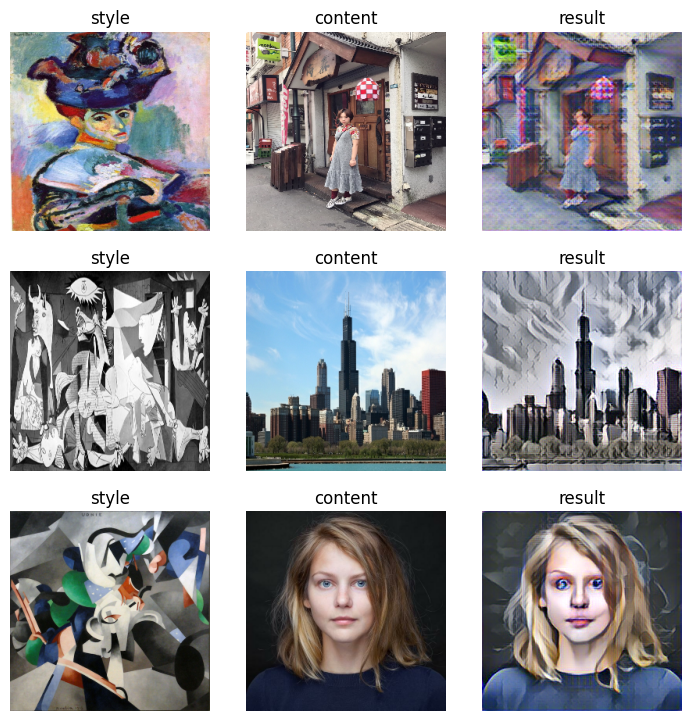

In [24]:

# Use the model to predict the values from the validation dataset.
for inputs,_ in validation.skip(2):
    inputs = tf.nest.map_structure(lambda x:x[:6],inputs)
    outputs = loaded(inputs)
    break

n_cols = 3
n_rows = 3
figure, axes = plt.subplots(n_rows, n_cols, figsize=(9,9), dpi=100)
for i in range(n_rows):
    axes[i,0].imshow(inputs['style'][i] / 255.)
    axes[i,0].set_title('style')
    axes[i,1].imshow(inputs['content'][i] / 255.)
    axes[i,1].set_title('content')
    axes[i,2].imshow(outputs[i] / 255.)
    axes[i,2].set_title('result')
for ax in axes.ravel():
    ax.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=.2)
# cm_image = plot_to_image(figure)    
# with file_writer_cm.as_default():
#     tf.summary.image("Model outputs", cm_image, step=epoch)
#     tf.summary.scalar('Content loss', data=stn.losses[0], step=epoch)
#     tf.summary.scalar('Style loss', data=stn.losses[1], step=epoch)
#     tf.summary.scalar('Total loss', data=tf.reduce_sum(stn.losses), step=epoch)

In [ ]:
plt.imshow(tf.reverse(w[1]/255.,axis=[-1]))

In [ ]:
tf.reduce_mean(w,[0,1,2])

In [ ]:
tb_start('kaggle_runs/results_v1/logs/',clean_first=False)

In [ ]:
loaded